## Life history traits model  
Taylor Chapter 3  
model to describe maturity ogives for understudied Carcharhinid species

script to test which depth measurement is the best

### Set up notebook

In [1]:
#import packages
import datetime 
from itertools import product
import logging
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import os
from math import isnan
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import seaborn as sns
import pymc3 as pm  
from theano import tensor as tt
from theano import shared
import arviz as az
import warnings

%matplotlib inline  
#%matplotlib inline is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object)
from matplotlib import pyplot as plt 
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter


In [2]:
# Aaron Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdise(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

In [3]:
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\in')
os.listdir() # list files in directory

['age_structured_traits.xlsx',
 'car_trait_covariates_v2.xlsx',
 'full_dataset.xlsx',
 'species_level_traits_v1.xlsx',
 '~$car_trait_covariates_v2.xlsx',
 '~$full_dataset.xlsx']

### Import and structure data

In [4]:
# Import full dataset
data = pd.read_excel('full_dataset.xlsx')
#get rid of species that don't have full complement of trait data
data = data[data.param_complete==0]
data.head()

Species     Stock   Stock_Year  Age  maturity survivorship  \
0  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    0  0.000000          NaN   
1  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    1  0.000000          NaN   
2  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    2  0.000000          NaN   
3  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    3  0.000000          NaN   
4  Carcharhinus tilstoni  ABTP-SWP  ABTP-SWP-13    4  0.016088          NaN   

   fecundity (num female pups per year) notes model type  source_mat  ...  \
0                                   NaN   NaN        NaN  Harry 2013  ...   
1                                   NaN   NaN        NaN  Harry 2013  ...   
2                                   NaN   NaN        NaN  Harry 2013  ...   
3                                   NaN   NaN        NaN  Harry 2013  ...   
4                                   NaN   NaN        NaN  Harry 2013  ...   

  linf_cm growth_coeff_k lmax_cm age_max_yrs temp_pref  nursery depth_min  \
0   218.0          0.089   166.0        15.0       0.0      0.0       0.0   
1   218.0          0.089   166.0        15.0       0.0      0.0       0.0   
2   218.0          0.089   166.0        15.0       0.0      0.0       0.0   
3   218.0          0.089   166.0        15.0       0.0      0.0       0.0   
4   218.0          0.089   166.0        15.0       0.0      0.0       0.0   

  depth_max depth_ave param_complete  
0     150.0      75.0            0.0  
1     150.0      75.0            0.0  
2     150.0      75.0            0.0  
3     150.0      75.0            0.0  
4     150.0      75.0            0.0  

[5 rows x 37 columns]

In [5]:
# Add  offspring size and  litter size relative to length at maturity
data['relative_litter_size'] = data.litter_size/data.length_maturity_cm
data['relative_offspring_size'] = (data.offspring_size_mm/10)/data.length_maturity_cm

In [6]:
#list columns
data.columns

Index(['Species', 'Stock', 'Stock_Year', 'Age', 'maturity', 'survivorship',
       'fecundity (num female pups per year)', 'notes', 'model type',
       'source_mat', 'source_sur', 'source_fec', 'source_m_link',
       'source_s_link', 'source_f_link', 'Cortes_2018', 'SA_mat', 'SA_sur',
       'SA_fec', 'FP_species', 'habitat', 'trophic_level', 'offspring_size_mm',
       'litter_size', 'interbirth_interval_yrs', 'age_50_maturity',
       'length_maturity_cm', 'linf_cm', 'growth_coeff_k', 'lmax_cm',
       'age_max_yrs', 'temp_pref', 'nursery', 'depth_min', 'depth_max',
       'depth_ave', 'param_complete', 'relative_litter_size',
       'relative_offspring_size'],
      dtype='object')

In [7]:
# make datafame of only stocks which have age-structured maturity data
# only data rows where SA-mat A
mdata= data[data.SA_mat=='A']
mdata.shape

(505, 39)

In [8]:
# make sure data is sorted properly
mdata = mdata.sort_values(by=['Stock_Year', 'Age'])

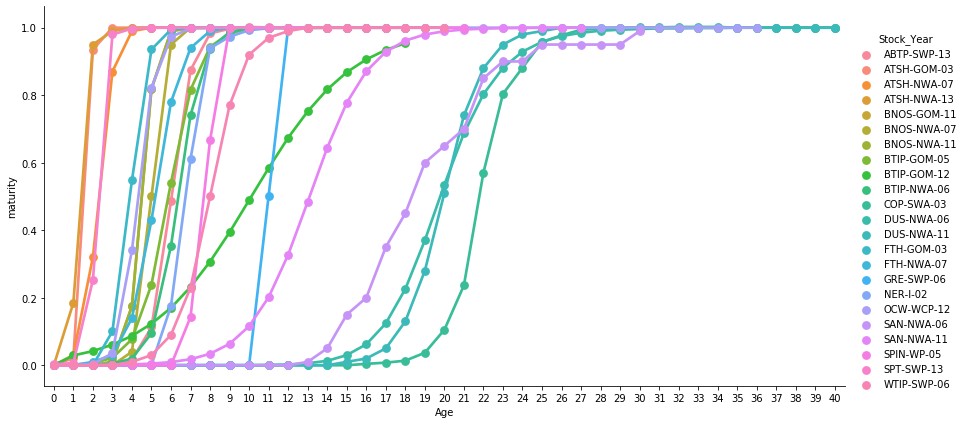

In [9]:
# visualise age-structured data
sns.catplot(x = "Age", y = "maturity", hue = "Stock_Year", height=6, aspect=2,
                kind="point", data = mdata);

## Format data

In [10]:
# Make arrays of response variables
AGE = mdata.Age.values
nobs = len(AGE)
MAT = mdata.maturity.values

In [11]:
# Make an index for stock-years 
# Puts an index value unique to the stock year for each row in df
StockYr, Is = indexall(mdata.Stock_Year.values)
nstocks = len(StockYr)
StockYr

['ABTP-SWP-13',
 'ATSH-GOM-03',
 'ATSH-NWA-07',
 'ATSH-NWA-13',
 'BNOS-GOM-11',
 'BNOS-NWA-07',
 'BNOS-NWA-11',
 'BTIP-GOM-05',
 'BTIP-GOM-12',
 'BTIP-NWA-06',
 'COP-SWA-03',
 'DUS-NWA-06',
 'DUS-NWA-11',
 'FTH-GOM-03',
 'FTH-NWA-07',
 'GRE-SWP-06',
 'NER-I-02',
 'OCW-WCP-12',
 'SAN-NWA-06',
 'SAN-NWA-11',
 'SPIN-WP-05',
 'SPT-SWP-13',
 'WTIP-SWP-06']

In [12]:
#Index of covariates
Sind = np.array([list(mdata.Stock_Year.values).index(S) for S in StockYr])

#make arrays of all the covariates
#put Sind after all of these so they match the length of StockYr
LMAX = mdata.lmax_cm.values[Sind]
HAB = mdata.habitat.values[Sind]
TROPH = mdata.trophic_level.values[Sind]
OFFSZ = mdata.offspring_size_mm.values[Sind]
ROFFSZ = mdata.relative_offspring_size.values[Sind]
LITT = mdata.litter_size.values[Sind]
RLITT = mdata.relative_litter_size.values[Sind]
INTR = mdata.interbirth_interval_yrs.values[Sind]
AMAT = mdata.age_50_maturity.values[Sind]
LMAT = mdata.length_maturity_cm.values[Sind]
LINF = mdata.linf_cm.values[Sind]
K = mdata.growth_coeff_k.values[Sind]
AMAX = mdata.age_max_yrs.values[Sind]
DEP = mdata.depth_ave.values[Sind]
DEPMAX = mdata.depth_max.values[Sind]
DEPMIN = mdata.depth_min.values[Sind]

In [13]:
# standardise continuous covariates
LMAX = stdise(LMAX)
TROPH = stdise(TROPH)
OFFSZ = stdise(OFFSZ)
ROFFSZ = stdise(ROFFSZ)
LITT = stdise(LITT)
RLITT = stdise(RLITT)
INTR = stdise(INTR)
LMAT = stdise(LMAT)
LINF = stdise(LINF)
K = stdise(K)
AMAX = stdise(AMAX)
DEP = stdise(DEP)
DEPMAX = stdise(DEPMAX)
DEPMIN = stdise(DEPMIN)

# Bayes model

Maturity model has 2 parts to assess the 2 parameters which describe the maturity curve

$$m = \frac{1}{1+e^{-S}(a-a_{50})}$$


a50 null model:
$$
\small{
a_{50} \sim Normal(Ga_{50},\sigma a_{50}) \\ 
Ga_{50} \sim Uniform(1.5, 25)  \\
\sigma a_{50} \sim Exponential(0.5) 
}
$$



S null model:
$$
\small{
S \sim Normal(GS,\sigma S) \\
GS \sim Uniform(0.01, 10)  \\
\sigma S \sim Exponential(1) 
}
$$

### Visualise Priors

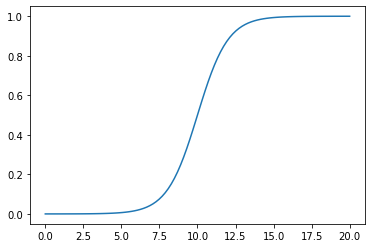

In [15]:
#make a figure of sigmoid with example maturity equation
def sigmoid(a):
    return(1/(1+np.exp(-1*(a-10))))
a = np.linspace(0,20,100)
plt.plot(a, sigmoid(a))

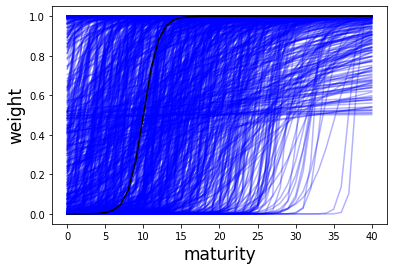

In [18]:
# try to visualise maturity slopes with prior a50 and S values
nsamp = 1000
a50 = np.random.normal(10, 10, nsamp)
S = np.random.exponential(1, nsamp)

ages = mdata.Age.unique()

#plot all possible ogives
[plt.plot(ages, 1/(1+np.exp(-S*(ages-a50))), c='blue', alpha=0.3) for a50,S in zip(a50, S)]
plt.xlabel('age', fontsize=10)
plt.ylabel('maturity', fontsize=10);

# a real ogive to see
plt.plot(ages, sigmoid(ages), c='black')

# Make it look nice
plt.xlabel('maturity', fontsize=17)
plt.ylabel('weight', fontsize=17);

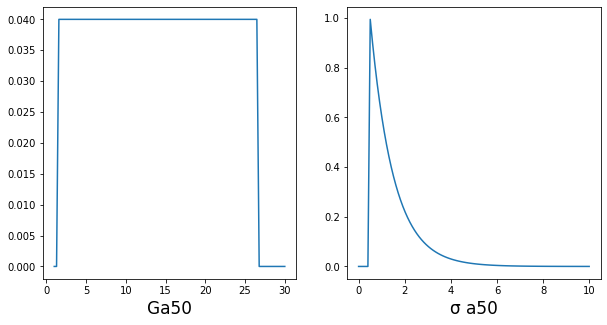

In [19]:
#visualise a50 priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of Ga50 prior
# create 100 values between 1 and 30
x = np.linspace(1, 30, 100) 
ax_[0].plot(x, sp.stats.uniform.pdf(x, 1.5, 25))
# specify labels for chart 1
ax_[0].set_xlabel('Ga50', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 0.5))
ax_[1].set_xlabel('σ a50', fontsize=17);

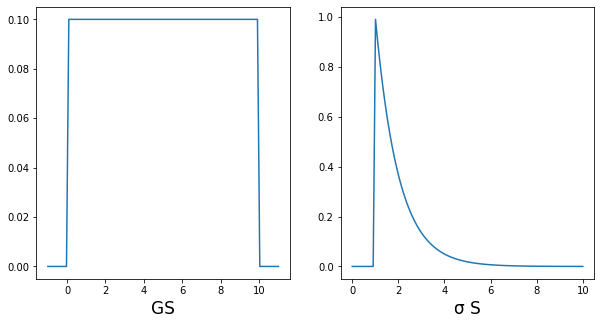

In [20]:
#visualise S priors here

# Setup multipanel figure
nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,5))
ax_ = axes.flatten()

# Plot range of GS prior
x = np.linspace(-1, 11, 100) #make the x axis
ax_[0].plot(x, sp.stats.uniform.pdf(x, 0.01, 10))
# specify labels for chart 1
ax_[0].set_xlabel('GS', fontsize=17)

# Plot range of sigma prior
#create 100 values between -10 and 60
x = np.linspace(0, 10, 100)
#what is the likelihood of each potential sigma value given your uniform prior where the mean=0 and std dev=50
ax_[1].plot(x, sp.stats.expon.pdf(x, 1))
ax_[1].set_xlabel('σ S', fontsize=17);

### Model Specification

In [14]:
# run a random effects model with a50 covariates only to see which depth measurment is the best
# start with average depth

with pm.Model() as dep1:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('Depth', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50

    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEP + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)

In [15]:
# Sampling
# go back to 5000 for final run
with dep1:
    trace1 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, Depth, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16476 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


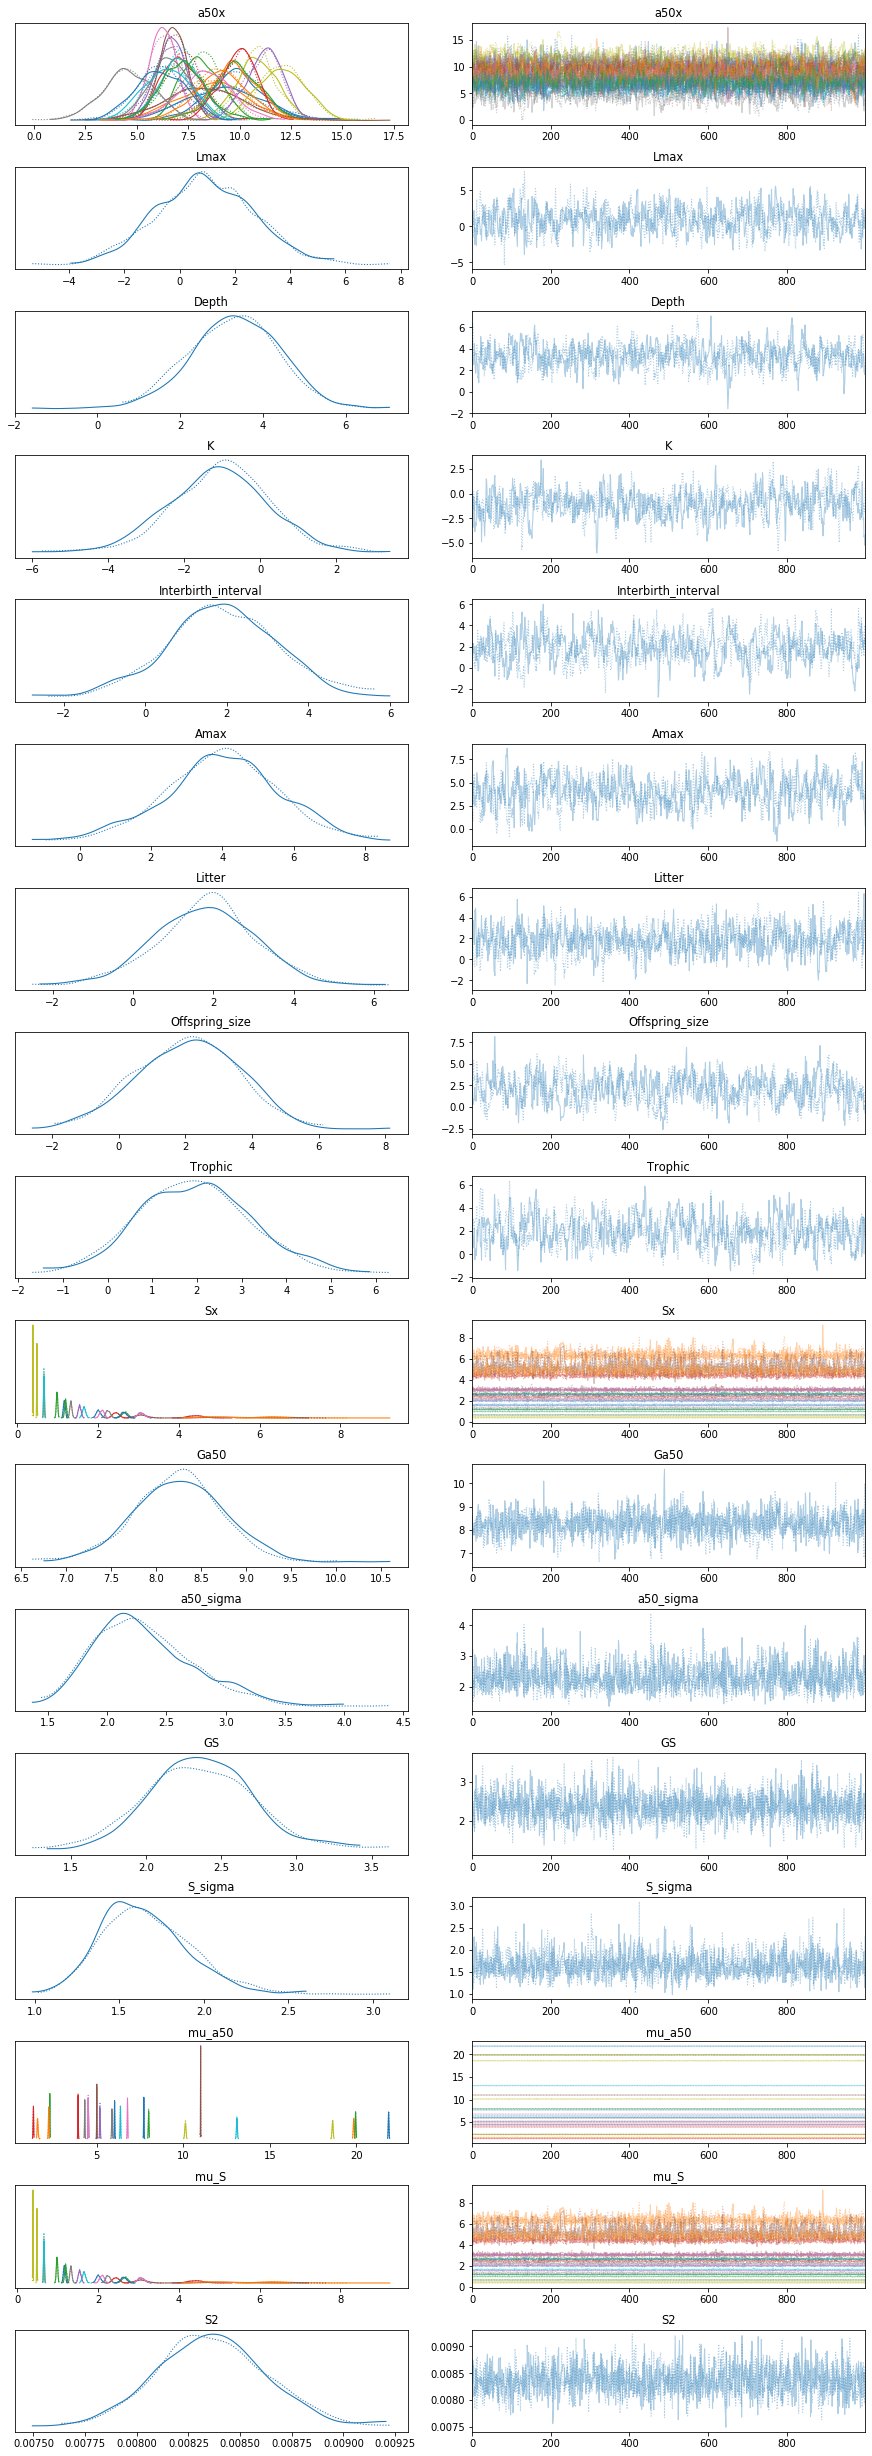

In [20]:
warnings.filterwarnings("ignore")
pm.traceplot(trace1);

In [16]:
# run a random effects model with a50 covariates only to see which depth measurment is the best
# now minimum depth

with pm.Model() as dep2:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('DepthMin', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50

    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEPMIN + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)

In [17]:
# Sampling
# go back to 5000 for final run
with dep2:
    trace2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, DepthMin, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16038 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


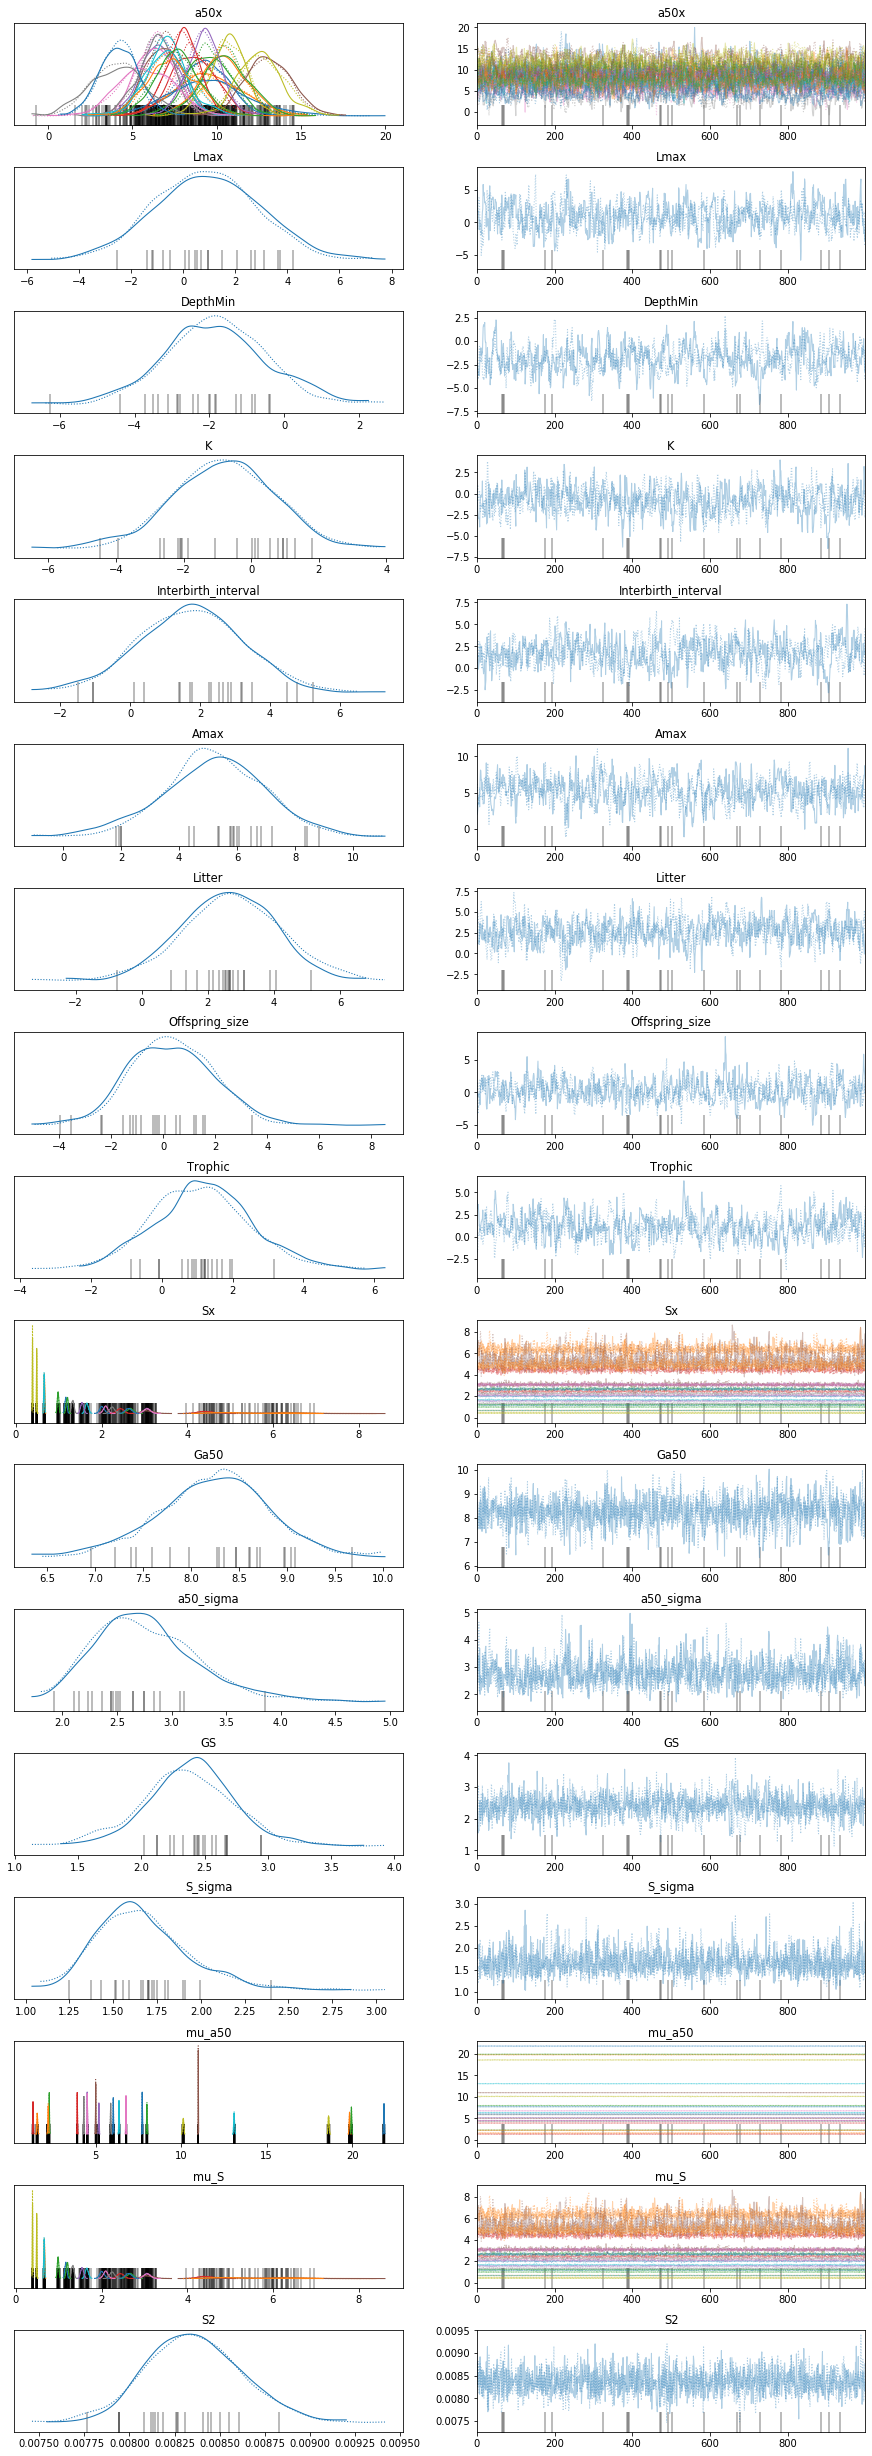

In [21]:
pm.traceplot(trace2);

In [18]:
# run a random effects model with a50 covariates only to see which depth measurment is the best
# now maximum depth

with pm.Model() as dep3:
    
    # Hierarchical a50
    Ga50 = pm.Uniform('Ga50', 1.5, 25) #mean a50 has uniform distribution from 1.5 to 25
    a50_sigma = pm.Exponential('a50_sigma', 0.5) #std dev of a50 is exponential distribution with lambda of 0.5
    a50 = pm.Normal('a50x', Ga50, a50_sigma, shape=nstocks) #likelihood of a50 values given distributions of Ga50 and sigma_a50 (I think... what is shape for?)
    # set up priors for slope values between a50 and covariates
    # first argument is just a name not an actual dataset - doesn't need to match name of data array
    β1 = pm.Normal('Lmax', 0, 3) 
   # β2 = pm.Normal('Linf', 0, 3) # don't use Linf bc same thing as Lmax, also effect too similar to K
    β3 = pm.Normal('DepthMax', 0, 3)
    β4 = pm.Normal('K', 0, 3)
   # β5 = pm.Normal ('Habitat', 0, 3) # How to set this up for a categorical variable?
    β6 = pm.Normal('Interbirth_interval', 0, 3)
    β7 = pm.Normal('Amax', 0, 3)
    β8 = pm.Normal('Litter', 0, 3)
    β9 = pm.Normal('Offspring_size', 0, 3)
    β10 = pm.Normal('Trophic', 0, 3)
  #  β11 = pm.Normal('Lmat', 0, 3)  # Don't use Lmat because same thing as a50

    
    # Hierarchical S
    # S is the curve parameter determining steepness/shape of maturity curve
    # GS is mean of distribution describing what S is
    # S_sigma is standard dev of distribution around GS
    GS = pm.Uniform('GS', 0.01, 10) # Uniform distribution of possible S values from 0.01 to 10
    S_sigma = pm.Exponential('S_sigma', 1) #Exponential distribution of possible sigma values with lambda of 1
    S = pm.Normal('Sx', GS, S_sigma, shape=nstocks) 
    
    # priors for covariates of S
    
    # a50 model
    # put all parameters that influence a50 here (all the β params from above)
    mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX + β3*DEPMAX + β4*K + β6*INTR + β7*AMAX + β8*LITT + β9*OFFSZ + β10*TROPH)
    #mu_a50 = pm.Deterministic("mu_a50", a50 + β1*LMAX) #try running model with 1 covariate to test for overfitting
 
    # Growth (S) model
    mu_S = pm.Deterministic("mu_S", S)
    
    # Growth model
    mu = 1/(1+tt.exp(-mu_S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-mu_a50[Is])))
    #mu = 1/(1+tt.exp(-S[Is]*(AGE-a50[Is])))

    # tt=under the hood modelling stuff - tensor flow package. makes exp work
    # Is is index values of stock codes

    # Likelihood
    S2 = pm.Uniform('S2', 0.0, 0.1) #variance for likelihood equation
    Yi = pm.Normal('Yi', mu, S2, observed=MAT)

In [19]:
# Sampling
# go back to 5000 for final run
with dep3:
    trace3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S2, Sx, S_sigma, GS, Trophic, Offspring_size, Litter, Amax, Interbirth_interval, K, DepthMax, Lmax, a50x, a50_sigma, Ga50]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16481 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


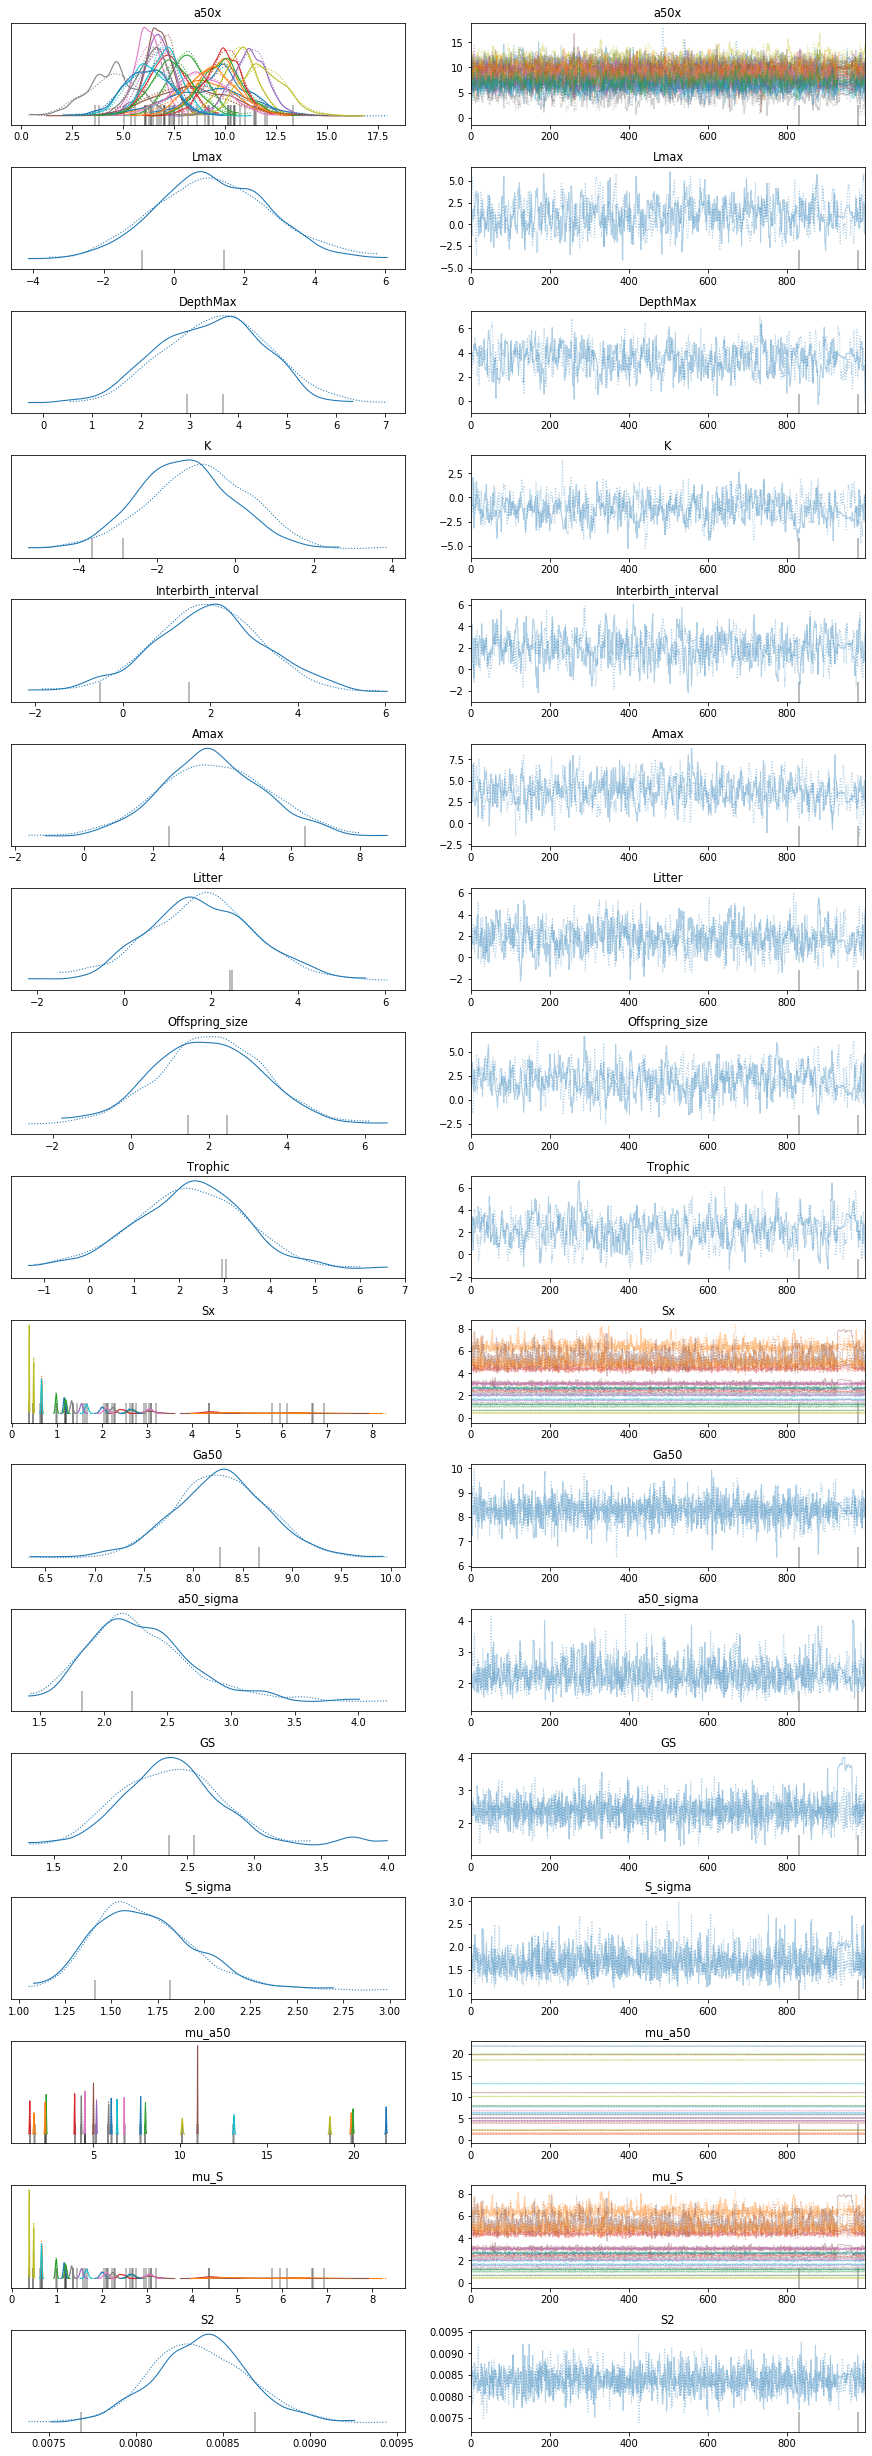

In [22]:
pm.traceplot(trace3);

In [23]:

pm.summary(trace1)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a50x[0]   9.805  1.376   7.253   12.498      0.082    0.058     282.0   282.0   
a50x[1]   8.596  1.687   5.404   11.820      0.081    0.057     433.0   433.0   
a50x[2]   8.172  0.963   6.454   10.000      0.061    0.044     248.0   245.0   
a50x[3]   7.223  0.962   5.521    9.059      0.061    0.044     248.0   245.0   
a50x[4]   6.671  0.795   5.225    8.129      0.043    0.030     348.0   348.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
mu_S[19]  0.658  0.010   0.640    0.674      0.000    0.000    2502.0  2501.0   
mu_S[20]  2.636  0.075   2.507    2.792      0.002    0.001    1983.0  1950.0   
mu_S[21]  4.941  0.404   4.280    5.725      0.011    0.008    1429.0  1326.0   
mu_S[22]  1.196  0.024   1.153    1.241      0.001    0.000    2187.0  2180.0   
S2        0.008  0.000   0.008    0.009      0.000    0.000    1778.0  1778.0   

          ess_bulk  ess_tail  r_hat  
a50x[0]      282.0     555.0   1.01  
a50x[1]      436.0     597.0   1.00  
a50x[2]      251.0     575.0   1.01  
a50x[3]      251.0     568.0   1.01  
a50x[4]      347.0     628.0   1.00  
...            ...       ...    ...  
mu_S[19]    2482.0    1486.0   1.00  
mu_S[20]    2046.0    1246.0   1.00  
mu_S[21]    1964.0    1089.0   1.00  
mu_S[22]    2190.0    1437.0   1.00  
S2          1744.0    1558.0   1.00  

[105 rows x 11 columns]

In [28]:
tracedepave = pm.summary(trace1)
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
tracedepave.to_csv('mat8_depave_trace.csv')

In [24]:
pm.summary(trace2)
# looking for r-hat valeus of 1 - shows that model is converging

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a50x[0]   9.144  1.568   6.102   11.911      0.082    0.058     368.0   368.0   
a50x[1]   9.541  1.964   5.970   13.247      0.098    0.070     398.0   394.0   
a50x[2]   9.562  1.307   7.041   12.079      0.082    0.058     254.0   254.0   
a50x[3]   8.614  1.308   6.135   11.138      0.082    0.058     254.0   254.0   
a50x[4]   6.671  1.083   4.652    8.710      0.066    0.048     272.0   257.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
mu_S[19]  0.658  0.010   0.637    0.675      0.000    0.000    1772.0  1770.0   
mu_S[20]  2.633  0.073   2.500    2.770      0.002    0.001    1626.0  1621.0   
mu_S[21]  4.967  0.436   4.260    5.825      0.015    0.011     879.0   806.0   
mu_S[22]  1.196  0.024   1.149    1.236      0.001    0.000    1590.0  1589.0   
S2        0.008  0.000   0.008    0.009      0.000    0.000    1949.0  1949.0   

          ess_bulk  ess_tail  r_hat  
a50x[0]      377.0     518.0   1.00  
a50x[1]      407.0     646.0   1.01  
a50x[2]      255.0     421.0   1.01  
a50x[3]      256.0     417.0   1.01  
a50x[4]      279.0     478.0   1.01  
...            ...       ...    ...  
mu_S[19]    1775.0    1528.0   1.00  
mu_S[20]    1639.0    1458.0   1.00  
mu_S[21]    1275.0     553.0   1.00  
mu_S[22]    1593.0    1326.0   1.00  
S2          1920.0    1237.0   1.00  

[105 rows x 11 columns]

In [25]:
pm.summary(trace3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
a50x[0]   9.875  1.304   7.295   12.327      0.056    0.040     539.0   539.0   
a50x[1]   8.574  1.755   5.443   12.022      0.084    0.060     431.0   426.0   
a50x[2]   8.117  0.894   6.453    9.747      0.051    0.036     310.0   310.0   
a50x[3]   7.168  0.895   5.497    8.783      0.051    0.036     309.0   309.0   
a50x[4]   6.743  0.774   5.185    8.146      0.038    0.027     416.0   415.0   
...         ...    ...     ...      ...        ...      ...       ...     ...   
mu_S[19]  0.657  0.010   0.640    0.675      0.000    0.000    1862.0  1862.0   
mu_S[20]  2.636  0.074   2.510    2.779      0.002    0.001    1379.0  1379.0   
mu_S[21]  4.956  0.423   4.299    5.814      0.013    0.010    1016.0   897.0   
mu_S[22]  1.196  0.023   1.151    1.234      0.001    0.000    1810.0  1807.0   
S2        0.008  0.000   0.008    0.009      0.000    0.000    1659.0  1659.0   

          ess_bulk  ess_tail  r_hat  
a50x[0]      545.0     754.0   1.00  
a50x[1]      432.0     636.0   1.01  
a50x[2]      313.0     414.0   1.00  
a50x[3]      311.0     411.0   1.00  
a50x[4]      416.0     546.0   1.01  
...            ...       ...    ...  
mu_S[19]    1803.0    1363.0   1.00  
mu_S[20]    1418.0    1356.0   1.00  
mu_S[21]    1497.0     734.0   1.00  
mu_S[22]    1838.0    1471.0   1.00  
S2          1623.0    1268.0   1.00  

[105 rows x 11 columns]

In [29]:
tracedepmax = pm.summary(trace3)
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
tracedepmax.to_csv('mat8_depmax_trace.csv')

In [ ]:
# now compare output of each model to see which depth measurement performs the best

### Model Results

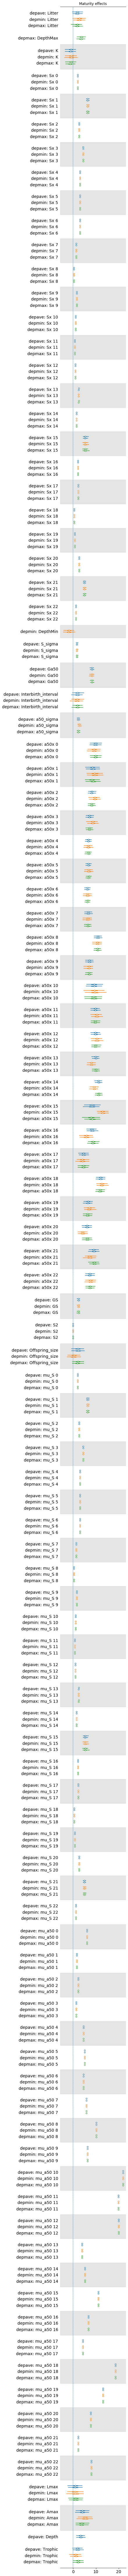

<Figure size 432x288 with 0 Axes>

In [27]:
# Forest plot to see size and direction of cov effects
# Compare dep1, 2 and 3
# az.style.use("arviz-darkgrid")
axes = az.plot_forest(
    [trace1, trace2, trace3], model_names=["depave", "depmin", "depmax"])
axes[0].set_title("Maturity effects")
plt.axvline(0, linestyle=':')
plt.show()

#save figure
os.chdir('C:\\Users\\tmgor\\Dropbox\\Taylor Chapter 3\\Data\\for model\\out')
plt.savefig('matdep_forest.jpg');

### Model Comparison

In [30]:
#WAIC for model 1
pm.waic(trace1, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3287.48   126.77
p_waic           91.29        -

There has been a warning during the calculation. Please check the results.

In [31]:
#WAIC for model 2
pm.waic(trace2, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3287.34   126.97
p_waic           90.82        -

There has been a warning during the calculation. Please check the results.

In [32]:
#WAIC for model 3
pm.waic(trace3, scale='deviance')

Computed from 2000 by 505 log-likelihood matrix

              Estimate       SE
deviance_waic -3287.31   126.68
p_waic           92.14        -

There has been a warning during the calculation. Please check the results.

Model 1 WAIC = -3286  
Model 2 WAIC = 181  

Model 1 vastly preferred over model 2 as lower WAIC better than higher

#### Look for 'bad' datapoints

In [33]:
loo1 = pm.loo(trace1, dep1)
loo1

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1636.46    63.00
p_loo       98.57        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      461   91.3%
 (0.5, 0.7]   (ok)         15    3.0%
   (0.7, 1]   (bad)        21    4.2%
   (1, Inf)   (very bad)    8    1.6%

In [34]:
loo2 = pm.loo(trace2, dep2)
loo2

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1636.22    62.71
p_loo       98.28        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      457   90.5%
 (0.5, 0.7]   (ok)         20    4.0%
   (0.7, 1]   (bad)        13    2.6%
   (1, Inf)   (very bad)   15    3.0%

In [35]:
loo3 = pm.loo(trace3, dep3)
loo3

Computed from 2000 by 505 log-likelihood matrix

         Estimate       SE
elpd_loo  1638.26    62.41
p_loo       97.54        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      462   91.5%
 (0.5, 0.7]   (ok)         14    2.8%
   (0.7, 1]   (bad)        22    4.4%
   (1, Inf)   (very bad)    7    1.4%